In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg as LA
from numpy.random import default_rng
import pywt
import ham_cr
import seaborn as sns

from keras.models import Sequential
from keras import optimizers
from keras import models
from keras import layers
from keras.layers import BatchNormalization
from keras.layers import Dropout

Using TensorFlow backend.


In [2]:
# @hidden_cell
# generate a complete data set of {cV, \chi_z, M_z} for one set of random Stevens parameters
# Comment: we could think to make a class that generates a full set of N training data sets (from N random Stevens parameters - then N would be given to the class). Here, the random drawing of Stevens parameters happens outside the class. 

class training_data:
    """
    Class generates and output training data: specific_heat(T), susceptibility(T) and magnetization(T, B) along specified direction(s). 
    (Optional) parameters that can be provided at instantiation: 
        point_group: Point group defined form of crystal field Hamiltonian (set to 'Oh' per default)
        N_t: Number of training sets = number of randomly chosen Stevens parameter sets. (Set to 1 per default)
        rng_seed: seed of random number generator that draws Stevens parameters (set to 1 per default)
        J, L, S: angular momentum of ion (set to J=4, L=5, S=1 per default)
        B_directions: magnetic field directions that are considered in susc and mag (set to [[0,0,1]] per default)

    Functions: 
    """

    # Bohr magneton over Boltzmann constant
    # Used to transform magnetic field B from unitsof Tesla to units of Kelvin: [muB*B/k_B] = Kelvin with [B] = Tesla
    muB_over_kB = 0.671713816 

    def __init__(self, point_group = 'Oh', N_t = 1, rng_seed = 1, J = 4, L = 5, S = 1, B_directions = [[0,0,1]]):
        self.point_group = point_group
        self.N_t = N_t
        self.rng_seed = rng_seed
        self.rg = default_rng(rng_seed)
        self.J = J
        self.L = L
        self.S = S
        self.B_directions = B_directions

    ###### define angular momentum operators Jx_op, Jy_op, Jz_op for a given J value #####
    def Jz_op(self):
        mat = np.diag(np.arange(2*self.J+1,dtype=np.float) - self.J)
        return mat

    def Jplus_op(self):
        mat = np.diag(np.sqrt((2*self.J - np.arange(2*self.J))*(np.arange(2*self.J)+1)), -1)
        return mat

    def Jminus_op(self):
        mat = np.diag(np.sqrt((2*self.J - np.arange(2*self.J))*(np.arange(2*self.J)+1)), 1)
        return mat

    def Jx_op(self):
        mat = (self.Jplus_op() + self.Jminus_op())/2.
        return mat

    def Jy_op(self):
        mat = -1j/2.*(self.Jplus_op() - self.Jminus_op())
        return mat

    def gJLS(self):
        return 1 + (self.J*(self.J + 1) + self.S*(self.S+1) - self.L*(self.L+1))/(2*self.J*(self.J + 1))

    ####### Draw random Stevens paramaters #######################################

    def generate_random_stevens(self, range):
        """
        Generated random values for Stevens parameters for given point group. 

        Parameters: 
            ppoint_group: string of point group in Schoenflies notation
            range: array of ranges for Stevens parameters [[x0_min, x0_max], [x1_min, x1_max], ...] 
        Returns: 
            stevens_params: array with random instances of Stevens parameters
        """
        # TO DO: implement error messages if range is not correct: in particular, it will get stuck if the range of the x_1, ..., x_{N-1} is not given by [-1,1]
        if self.point_group == 'Oh': # two Stevens parameters for m-3m = Oh point group
            x0 = (range[0][0] + (range[0][1] - range[0][0])*self.rg.random())*self.rg.choice([-1,1])
            x1 = range[1][0] + (range[1][1] - range[1][0])*self.rg.random()
            stevens_params = np.array([x0, x1])
        elif self.point_group == "C4v": # 5 Stevens parameters for 4mm = C4v point group
            stevens_params = np.array([1.,1.,1.,1.,1., 0.])
            while (np.sum(np.abs(stevens_params)) - np.abs(stevens_params[0]) - np.abs(stevens_params[-1]) > 1):
                stevens_params[0] = (range[0][0] + (range[0][1] - range[0][0])*self.rg.random())*self.rg.choice([-1,1])
                stevens_params[1] = range[1][0] + (range[1][1] - range[1][0])*self.rg.random()
                stevens_params[2] = range[2][0] + (range[2][1] - range[2][0])*self.rg.random()
                stevens_params[3] = range[3][0] + (range[3][1] - range[3][0])*self.rg.random()
                stevens_params[4] = range[4][0] + (range[4][1] - range[4][0])*self.rg.random()
            stevens_params[5] = 2.*self.rg.random() - 1. # only sign of x5 matters as size is determined by x1, .., x4. 
        elif self.point_group == "D3h": # 4 Stevens parameters for -6m2 = D3h point group
            stevens_params = np.array([1.,1.,1.,1., 0.])
            while (np.sum(np.abs(stevens_params)) - np.abs(stevens_params[0]) - np.abs(stevens_params[-1]) > 1):
                stevens_params[0] = (range[0][0] + (range[0][1] - range[0][0])*self.rg.random())*self.rg.choice([-1,1])
                stevens_params[1] = range[1][0] + (range[1][1] - range[1][0])*self.rg.random()
                stevens_params[2] = range[2][0] + (range[2][1] - range[2][0])*self.rg.random()
                stevens_params[3] = range[3][0] + (range[3][1] - range[3][0])*self.rg.random()
            stevens_params[4] = 2.*self.rg.random() - 1. # only sign of x5 matters as size is determined by x1, .., x4. 
        else:
            raise ValueError("This point group is not implemented.")
        return stevens_params
            
    ####### Define the crystal field Hamiltonian for given point group and J ##########
    def ham_cr(self, stevens_params):
        """
        Outputs crystal field Hamiltonian H in units of Kelvin. The units of H are set by the units of x0. We choose the range of x0 (=[1,50] Kelvin) that corresponds to [x0] = Kelvin. 

        Parameters: 
            stevens_params: array of Stevens parameters (check that length is correct). x0 has dimensions of energy (we use Kelvin) and x1, x2, ... are dimensionless in interval [-1,1].
        Returns: 
            ham_cr: crystal field Hamiltonian array 
        """
        if (self.point_group == 'Oh'):  
            if (len(stevens_params) != 2): 
                raise ValueError("Number of Stevens parameters should be 2 for point group Oh")
            if (self.J == 4):
                return ham_cr.ham_cr_PG_Oh_J_4(stevens_params[0], stevens_params[1])
            elif (self.J == 7.5):
                return ham_cr.ham_cr_PG_Oh_J_7_5(stevens_params[0], stevens_params[1])
            elif (self.J == 3.5):
                return ham_cr.ham_cr_PG_Oh_J_3_5(stevens_params[0], stevens_params[1])
            elif (self.J == 6):
                return ham_cr.ham_cr_PG_Oh_J_6(stevens_params[0], stevens_params[1])
            elif (self.J == 8):
                return ham_cr.ham_cr_PG_Oh_J_8(stevens_params[0], stevens_params[1])
            elif (self.J == 4.5):
                return ham_cr.ham_cr_PG_Oh_J_4_5(stevens_params[0], stevens_params[1])
        elif (self.point_group == 'C4v'): 
            if (len(stevens_params) != 6): 
                raise ValueError("Number of Stevens parameters should be 5+1=6 for point group C4v")
            if (self.J == 4):
                return ham_cr.ham_cr_PG_C4v_J_4(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4], stevens_params[5])
            elif (self.J == 7.5):
                return ham_cr.ham_cr_PG_C4v_J_7_5(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4], stevens_params[5])
            elif (self.J == 3.5):
                return ham_cr.ham_cr_PG_C4v_J_3_5(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4], stevens_params[5])
            elif (self.J == 6):
                return ham_cr.ham_cr_PG_C4v_J_6(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4], stevens_params[5])
            elif (self.J == 8):
                return ham_cr.ham_cr_PG_C4v_J_8(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4], stevens_params[5])
            elif (self.J == 4.5):
                return ham_cr.ham_cr_PG_C4v_J_4_5(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4], stevens_params[5])

        elif (self.point_group == 'D3h'): 
            if (len(stevens_params) != 5): 
                raise ValueError("Number of Stevens parameters should be 4+1=5 for point group D3h")
            if (self.J == 4):
                return ham_cr.ham_cr_PG_D3h_J_4(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4])
            elif (self.J == 7.5):
                return ham_cr.ham_cr_PG_D3h_J_7_5(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4])
            elif (self.J == 3.5):
                return ham_cr.ham_cr_PG_D3h_J_3_5(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4])
            elif (self.J == 6):
                return ham_cr.ham_cr_PG_D3h_J_6(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4])
            elif (self.J == 8):
                return ham_cr.ham_cr_PG_D3h_J_8(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4])
            elif (self.J == 4.5):
                return ham_cr.ham_cr_PG_D3h_J_4_5(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4])
        else: 
            raise ValueError("This point group and/or value of J is not implemented.")   

    ####### Calculate specific heat ##################################

    def specific_heat(self, ham, T_min=2, T_max=300, T_steps=150):
        """
        Returns array of cV/kB for a single rare-earth ion over temperature range [T_min, T_max] for hamiltonian matrix ham. Note that [cV/kB] is dimensionless. To get the specific heat, multiply the result with the Boltzmann constant kB. 

        Parameters: 
            ham : hermitian Hamiltonian matrix, typically of crystal field Hamiltonian (dimension 2*J+1)
            T_min : minimal temperature in Kelvin
            T_max : maximal temprature in Kelvin
            T_steps: total number of steps in temperature range

        Returns: 
            cV_array: cV/kB for a single rare-earth ion. Array of dimension (T_steps, 2) containing (T_i, cV/kB(T_i) ),             where T_i is temperature at step i 

        """  
        T = np.linspace(T_min, T_max, T_steps) # linearly spaced temperatures
        energies = LA.eigvalsh(ham)
        energies = energies - energies[0]

        # partition function for zero field
        def Z_cr(T):
            return np.sum(np.exp(-energies/T))
        
        # specific heat expression
        def cV(T):
            return 1./(T**2) * (np.sum(energies**2 * np.exp(-energies/T))/Z_cr(T) - np.sum(energies * np.exp(-energies/T)/Z_cr(T))**2)

        cV_array = np.zeros((len(T), 2))

        #this can probably be optimized using numpy ufuncs, but it is ok for now
        for i in range(0, len(cV_array)):
            cV_array[i][0] = T[i]
            cV_array[i][1] = cV(T[i])
    
        return cV_array

    ######### Calculate magnetization ##############################

    def magnetization(self, ham_cr, B_direction, B_min=0, B_max=10, B_steps=20, T_min=2, T_max=300, T_steps=4):
        """
        Returns array of moment per R-ion mu/mu_B (over mu_B) over temperature and magnetic field range [T_min, T_max] and [B_min, B_max] for a system with zero-field Hamiltonian matrix ham_cr. Note mu/mu_B is dimensionless. The magnetic field is along B_direction (x, y, z).  
        Parameters: 
            ham_cr : hermitian Hamiltonian matrix in zero field, typically of crystal field Hamiltonian (dimension 2*J+1)
            B_direction: (B_x, B_y, B_z) triple denoting the field direction in real space
            B_min: minimal field (in Tesla)
            B_max: maximal field (in Tesla)
            B_steps: total number of steps in field range
            T_min : minimal temperature in Kelvin
            T_max : maximal temprature in Kelvin
            T_steps: total number of steps in temperature range

        Returns: 
            mag_array: induced moment on R-ion mu/muB in array of dimension (T_steps, B_steps, 2) containing (B_i, T_i, mag(B_i, T_i) ), where T_i (B_i) is temperature (field) at step i. Note that this differs by a factor of gJLS from a previous version of the function. 

        """  
        gJLS = float(self.gJLS())

        T_array = np.geomspace(T_min, T_max, T_steps)
        B_array = np.linspace(B_min, B_max, B_steps)

        B_direction = B_direction/LA.norm(B_direction)
        J_op = B_direction[0]*self.Jx_op() + B_direction[1]*self.Jy_op() + B_direction[2]*self.Jz_op()

        mag_array = np.zeros((len(B_array), len(T_array), 3))

        # this can probably be optimized using numpy ufuncs, but it is ok for now
        for B_idx in np.arange(0, len(B_array)):
            B = B_array[B_idx]
            ham = ham_cr - gJLS*self.muB_over_kB*J_op*B
            energies, eigenstates = LA.eigh(ham)
            energies = energies - energies[0]
            
            for T_idx in range(0, len(T_array)):
                T = T_array[T_idx]
                ZB = np.sum(np.exp(-energies/T))
                # mag = \mu/\mu_B is moment per R-ion over Bohr magneton. mag is dimensionless. 
                mag = gJLS/ZB*np.sum([np.dot(np.conjugate(eigenstates[:,i]), np.dot(J_op, eigenstates)[:, i])*np.exp(-energies[i]/T) for i in range(0, len(energies))])
    
                mag_array[B_idx][T_idx][0] = B_array[B_idx]
                mag_array[B_idx][T_idx][1] = T_array[T_idx]
                mag_array[B_idx][T_idx][2] = mag

        return mag_array
    
    ########### Calculate magnetic susceptibility ############################
    
    def susceptibility(self, ham_cr, B_direction, B=0.0001, T_min=1, T_max=300, T_steps=300):
        """
        Calculated and returns magnetic susceptibility chi_a = mu/(mu_B*B) (units of 1/T) over temperature range [T_min, T_max] for zero-field Hamiltonian matrix ham_cr. Here, mu is the induced moment on the R-ion, mu_B is the Bohr magneton and B the magnetic field. The direction is a=B_direction .
        Parameters: 
            ham_cr : hermitian Hamiltonian matrix in zero field, typically a crystal field Hamiltonian (dimension 2*J+1)
            B_direction: (B_x, B_y, B_z) triple denoting the field direction in real space
            B: B field used in susceptibility calculation (in Tesla). Should be << all other energy scales. 
            T_min : minimal temperature in Kelvin
            T_max : maximal temprature in Kelvin
            T_steps: total number of steps in temperature range
            
        Returns: 
            susc_array: array of dimension (T_steps, 2) containing (T_i, mu(T_i)/(muB*B), where T_i is temperature at step i and mu(T_i)/mu_B = mag(T_i) is the field induced moment on the R-ion. Note that this differs by a factor of gJLS from a previous version of the function. 

        """  
        gJLS = float(self.gJLS())

        T_array = np.linspace(T_min, T_max, T_steps)

        B_direction = B_direction/LA.norm(B_direction)
        J_op = B_direction[0]*self.Jx_op() + B_direction[1]*self.Jy_op() + B_direction[2]*self.Jz_op()

        susc_array = np.zeros((len(T_array), 2))

        # this can probably be optimized using numpy ufuncs, but it is ok for now  
        # B is given in units of T, ham is in units of K.
        ham = ham_cr - gJLS*self.muB_over_kB*J_op*B
        energies, eigenstates = LA.eigh(ham)
        energies = energies - energies[0]
            
        for T_idx in range(0, len(T_array)):
                T = T_array[T_idx]
                ZB = np.sum(np.exp(-energies/T))
                # mag = mu/mu_B, where \mu is the field induced moment on the R-ion
                mag = gJLS/ZB*np.sum([np.dot(np.conjugate(eigenstates[:,i]), np.dot(J_op, eigenstates)[:, i])*np.exp(-energies[i]/T) for i in range(0, len(energies))])

                susc_array[T_idx][0] = T_array[T_idx]
                # susc = mag/B = \mu/(\mu_B B) has units of 1/T
                susc_array[T_idx][1] = mag/B 

        return susc_array

    ######## Output training data into files #################

    def output_all_data(self, coeff, cV_T_range = [1, 300, 100], susc_T_range = [1, 300, 100], mag_T_range = [1, 300, 4], mag_B_range = [0.5, 10, 20]):
        """
        Write training data to file
        Parameters: 
            Stevens_range: array of ranges for Stevens parameters [[x0_min, x0_max], [x1_min, x1_max], ...] 
        Optional parameters: 
            cV_T_range: [T_min, T_max, T_steps] array for specific heat calculation
            susc_T_range: [T_min, T_max, T_steps] array for susceptibility calculation
            mag_T_range: [T_min, T_max, T_steps] array for magnetization calculation
            mag_B_range: [B_min, B_max, B_steps], where B_steps is the number of B points within range [B_min, B_max]
            coeff: Stevens coefficients to generate data
        Returns: 
            stevens_params_all: array with parameter values of Stevens parameters
            cV_data_all: array with specific heat values
            susc_data_all: array with susceptibility values
            mag_data_all: array with magnetization values

        """
        stevens_params_all = [] 
        cV_data_all = []
        susc_data_all = []
        mag_data_all = []
        
        stevens_params = coeff
        stevens_params_all.append(stevens_params) # use a list to store all Stevens parameters. Since different point groups have different number of Stevens parameters, the tuples that are stored have different length. 
        ham_cr = self.ham_cr(stevens_params) # crystal field Hamiltonian for given random Stevens parameters

        # generate specific heat data and store in cV_data
        cV_data_all.append(self.specific_heat(ham_cr, T_min = cV_T_range[0], T_max = cV_T_range[1], T_steps = cV_T_range[2]))

        B_direction_steps = len(self.B_directions)

        # generate susceptibility data and store in susc_data (for all B_directions)
        susc_data = np.zeros((susc_T_range[2], 1 + B_direction_steps))
        mag_data = np.zeros((mag_B_range[2], mag_T_range[2], 2 + B_direction_steps))

        for B_direction_idx in range (0, B_direction_steps):
            B_direction = self.B_directions[B_direction_idx]
            susc_array = self.susceptibility(ham_cr, B_direction, B = 0.0001, T_min = susc_T_range[0], T_max = susc_T_range[1], T_steps = susc_T_range[2])
            mag_array = self.magnetization(ham_cr, B_direction, B_min = mag_B_range[0], B_max = mag_B_range[1], B_steps = mag_B_range[2], T_min = mag_T_range[0], T_max = mag_T_range[1], T_steps = mag_T_range[2])

            for T_idx in range (0, len(susc_array)):
                if (B_direction_idx == 0): 
                    susc_data[T_idx][0] = susc_array[T_idx][0]
                susc_data[T_idx][1 + B_direction_idx] = susc_array[T_idx][1]

            for B_idx in range (0, mag_B_range[2]):
                for T_idx in range(0, mag_T_range[2]):
                    if (B_direction_idx == 0):
                        mag_data[B_idx][T_idx][0] = mag_array[B_idx][T_idx][0]
                        mag_data[B_idx][T_idx][1] = mag_array[B_idx][T_idx][1]
                    mag_data[B_idx][T_idx][2 + B_direction_idx] = mag_array[B_idx][T_idx][2]
        susc_data_all.append(susc_data)
        mag_data_all.append(mag_data)
        return stevens_params_all, cV_data_all, susc_data_all, mag_data_all
            

In [3]:
def cwt(data, channels=6, wavelet='morl'):
    """
    Applies the continuous wavelet transformation on each dataset (susc, spec heat, magnetization at 4 temps) individually
    and combines each convolution into a multi-channel image to be fed to the CNN
    Args:
        data: 1D array containing each dataset
        channels: number of channels in the output image (susc, spec heat, magnetization at 4 temps)
        waveletname: mother wavelet function to be used Can be any from 
            https://pywavelets.readthedocs.io/en/latest/ref/wavelets.html, specifically pywt.wavelist()

    Returns:
        Input data reshaped into a (shape x shape) image with 'channels' channels
    """
    shape = data.shape[1]//channels
    size = data.shape[0]
    scales = np.linspace(1, 200, shape)

    data_cwt = np.ndarray(shape=(size, shape, shape, channels), dtype=np.float16)
    for i in range(size):
        if (i % 1000 == 0):
            print('.', end='')

        # generating each of the channels
        for j in range(channels):
            signal = data[i][j*shape: shape+(j*shape)]
            coeff, freq = pywt.cwt(signal, scales, wavelet, 1)
            data_cwt[i, :, :, j] = coeff

    return data_cwt

In [4]:
num_training_examples = 1
J = 15/2 #4
L = 6 #5
S = 3/2 #1
pg = 'Oh'
B_directions=[[1,1,1]] #,[0,0,1]]
Stevens_range = [[0.5, 50],[-1,1]] #,[-1,1],[-1,1],[-1,1]]

td = training_data(pg, num_training_examples, 123, J, L, S, B_directions)

#out[0] # Stevens parameters
#out[1] # specific heat [[T_i, cV^(0)_i], [T_i, cV^(1)_i], ..., [T_i, cV^(N_t-1)_i] ], i = 1, ..., T_steps
#out[2] # susceptibility [[T_i, susc^(0)_{0,i}, susc^{(0)_{1,i}, ..., susc^(0)_{B_direction-1,i}}], ...], i = 1, ..., T_steps
#out[3] # magnetization [[[B_j, T_i, M^(0),{0,i}, M^(0)_{1,i,j}, ..., M^(0)_{B_direction-1,i,j}], ... ]], j = 1, .., B_steps; i = 1, ..., T_steps

In [5]:
group = 'Oh'
J = '7.5'
# dir = './TrainingData_{}_{}/'.format(group, J)
dir = './Experimental_network/'
dir_pos = dir + 'Experimental_network_1/'
dir_neg = dir + 'Experimental_network_-1/'

data_pos = dir_pos + 'generated_data_{}.csv'
targets_pos = dir_pos + 'generated_targets_{}.csv'
data_neg = dir_neg + 'generated_data_{}.csv'
targets_neg = dir_neg + 'generated_targets_{}.csv'

In [6]:
x_train = np.array(pd.read_csv(data_pos.format(1000), header=None))
y_train = np.array(pd.read_csv(targets_pos.format(1000), header=None))
channels = len(x_train[0])//64

In [7]:
x_mean_pos = np.load(dir_pos + 'x_mean_{}_{}.npy'.format(group, J))
y_mean_pos = np.load(dir_pos + 'y_mean_{}_{}.npy'.format(group, J))
y_std_pos = np.load(dir_pos + 'y_std_{}_{}.npy'.format(group, J))

x_mean_neg = np.load(dir_neg + 'x_mean_{}_{}.npy'.format(group, J))
y_mean_neg = np.load(dir_neg + 'y_mean_{}_{}.npy'.format(group, J))
y_std_neg = np.load(dir_neg + 'y_std_{}_{}.npy'.format(group, J))

In [8]:
model = models.Sequential()

model.add(layers.Conv2D(96, (3, 3), activation='relu', input_shape=(64, 64, channels)))
model.add(layers.Conv2D(96, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Flatten())

model.add(layers.Dense(4096, activation='relu'))
model.add(layers.BatchNormalization())
model.add(Dropout(0.3))

model.add(layers.Dense(2048, activation='relu'))
model.add(layers.BatchNormalization())
model.add(Dropout(0.3))

model.add(layers.Dense(len(y_train[0])))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 96)        2688      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 96)        83040     
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 96)        384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       221440    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 256)       590080    
_________________________________________________________________
batch_normalization_2 (Batch (None, 26, 26, 256)      

In [9]:
from keras.models import load_model
model_pos = load_model(dir_pos + '{}_{}_1_model.h5'.format(group, J))
model_neg = load_model(dir_neg + '{}_{}_-1_model.h5'.format(group, J))

In [10]:
def predict(data):
    """
    """
    data_cwt = cwt(np.array([data]), channels=channels)
    data_cwt -= x_mean_neg
    pred_neg = model_neg.predict(data_cwt)
    pred_neg = (pred_neg * y_std_neg) + y_mean_neg
    
    data_cwt = cwt(np.array([data]), channels=channels)
    data_cwt -= x_mean_pos
    pred_pos = model_pos.predict(data_cwt)
    pred_pos = (pred_pos * y_std_pos) + y_mean_pos

    return {"pos": pred_pos, "neg": pred_neg}

In [11]:
def mse_generated_data(real_y, pred_y):
    """
    """
    B_temps = 1
    real_out = td.output_all_data(real_y, cV_T_range = [2, 22, 64], susc_T_range = [2, 300, 64], mag_T_range = [2, 2, B_temps], mag_B_range = [0.5, 5.5, 64])
    pred_out = td.output_all_data(pred_y, cV_T_range = [2, 22, 64], susc_T_range = [2, 300, 64], mag_T_range = [2, 2, B_temps], mag_B_range = [0.5, 5.5, 64])
    
    error = 0
    error += sum([(yr - yp)**2 for (yr, yp) in zip(np.array(real_out[1])[:,:,1].flatten(), np.array(pred_out[1])[:,:,1].flatten())])
    for i in range(len(B_directions)): # size of B_directions
        error += sum([(yr -yp)**2 for (yr, yp) in zip(np.array(real_out[2])[:,:,i+1].flatten(), np.array(pred_out[2])[:,:,i+1].flatten())])
    for i in range(B_temps): # T step for magnetization
        for j in range(len(B_directions)): # size of B_directions
            error += sum([(yr -yp)**2 for (yr, yp) in zip(np.array(real_out[3])[:,:,i,j+2].flatten(), np.array(pred_out[3])[:,:,i,j+2].flatten())])
    return error / len(x_train[0])

In [19]:
N = 2000
y_real_pos = np.array(pd.read_csv(targets_pos.format(N), header=None))
x_pos = np.array(pd.read_csv(data_pos.format(N), header=None))
y_real_neg = np.array(pd.read_csv(targets_neg.format(N), header=None))
x_neg = np.array(pd.read_csv(data_neg.format(N), header=None))

x_pos = cwt(x_pos, channels=channels)
x_pos -= x_mean_pos
y_pred_pos = model_pos.predict(x_pos)
y_pred_pos = (y_pred_pos * y_std_pos) + y_mean_pos
x_neg = cwt(x_neg, channels=channels)
x_neg -= x_mean_neg
y_pred_neg = model_neg.predict(x_neg)
y_pred_neg = (y_pred_neg * y_std_neg) + y_mean_neg

....

In [20]:
errors_pos = [mse_generated_data(y_real_pos[i], y_pred_pos[i]) for i in range(len(y_real_pos))]
errors_neg = [mse_generated_data(y_real_neg[i], y_pred_neg[i]) for i in range(len(y_real_neg))]

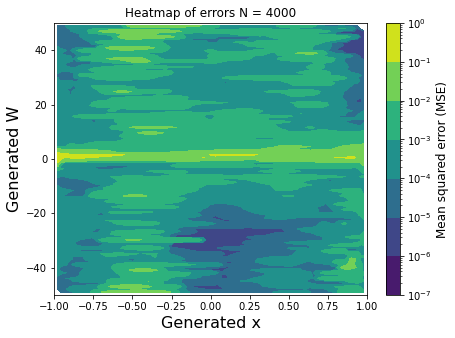

In [23]:
import matplotlib.tri as tri
from matplotlib import ticker, cm

y_all = np.concatenate((y_real_pos, y_real_neg))
errors_all = np.concatenate((errors_pos, errors_neg))

xi = np.linspace(-1, 1, 100)
yi = np.linspace(-50, 50, 100)
triang = tri.Triangulation(y_all[:,1], y_all[:,0])
interpolator = tri.LinearTriInterpolator(triang, errors_all)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,5))

plt.xlabel('Generated x', fontsize=16)
plt.ylabel('Generated W', fontsize=16)
plt.title('Heatmap of errors N = {}'.format(N*2))
cs = ax.contourf(Xi, Yi, zi, locator=ticker.LogLocator(), cmap=cm.viridis)
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('Mean squared error (MSE)', fontsize=12)
# ax.plot(y_all[:,1], y_all[:,0], 'ko', ms=3)

plt.show()

## Experimental data comparison

In [15]:
import scipy as sp
import scipy.interpolate

mag = np.array(pd.read_csv(dir + 'Mag_H.csv')) # mag
mag_x = np.linspace(mag[:, 1].min(), mag[:, 1].max(), 64)
mag = sp.interpolate.interp1d(mag[:, 1], mag[:, 2], kind='cubic')(mag_x)

spec = np.array(pd.read_csv(dir + 'cM_T_exact.csv', header=None)) # specific heat
# spec = np.array(pd.read_csv(dir + 'cM_T.csv'))
spec_x = np.linspace(spec[:, 0].min(), spec[:, 0].max(), 64)
spec = sp.interpolate.interp1d(spec[:, 0], spec[:, 2], kind='cubic')(spec_x)

inverse_chi = np.array(pd.read_csv(dir + 'Inverse_chi_full_T.csv'))
low_t_chi = np.array(pd.read_csv(dir + 'chi_low_T.csv'))

chi_x_temp = np.concatenate([low_t_chi[:, 0], inverse_chi[:, 0]]) # susc
chi = np.concatenate([low_t_chi[:, 2], inverse_chi[:, 3]])
chi_x = np.linspace(chi_x_temp.min(), chi_x_temp.max(), 64)
chi = sp.interpolate.interp1d(chi_x_temp, chi, kind='cubic')(chi_x)

exp_data = np.concatenate([spec, chi, mag])
exp_cwt_data = cwt(np.array([exp_data]), channels=channels)
preds = predict(exp_data)
preds

...

{'pos': array([[16.49042728, -0.03268446]]),
 'neg': array([[-24.0305022 ,  -0.39181882]])}

In [16]:
exp_out_pos = td.output_all_data(preds['pos'][0], cV_T_range = [2, 22, 64], susc_T_range = [2, 300, 64], mag_T_range = [2, 2, 1], mag_B_range = [0, 5.5, 64])
exp_out_neg = td.output_all_data(preds['neg'][0], cV_T_range = [2, 22, 64], susc_T_range = [2, 300, 64], mag_T_range = [2, 2, 1], mag_B_range = [0, 5.5, 64])

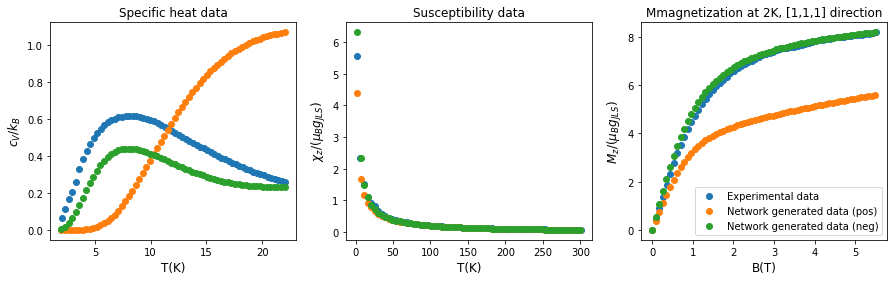

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))
ax[0].scatter(spec_x, spec) # specific heat
ax[0].scatter(np.array(exp_out_pos[1])[:,:,0].flatten(), np.array(exp_out_pos[1])[:,:,1].flatten())
ax[0].scatter(np.array(exp_out_neg[1])[:,:,0].flatten(), np.array(exp_out_neg[1])[:,:,1].flatten())
ax[0].set_xlabel('T(K)', fontsize=12)
ax[0].set_ylabel('$c_V/k_B$', fontsize=12)
ax[0].set_title('Specific heat data', fontsize=12)

ax[1].scatter(chi_x, chi) # susc
ax[1].scatter(np.array(exp_out_pos[2])[:,:,0].flatten(), np.array(exp_out_pos[2])[:,:,1].flatten())
ax[1].scatter(np.array(exp_out_neg[2])[:,:,0].flatten(), np.array(exp_out_neg[2])[:,:,1].flatten())
ax[1].set_xlabel('T(K)', fontsize=12)
ax[1].set_ylabel('$\chi_z/(\mu_B g_{JLS})$', fontsize=12)
ax[1].set_title('Susceptibility data', fontsize=12)

ax[2].scatter(mag_x, mag, label='Experimental data') # susc
ax[2].scatter(np.array(exp_out_pos[3])[:,:,0,0].flatten(), np.array(exp_out_pos[3])[:,:,0,2].flatten(), label='Network generated data (pos)')
ax[2].scatter(np.array(exp_out_neg[3])[:,:,0,0].flatten(), np.array(exp_out_neg[3])[:,:,0,2].flatten(), label='Network generated data (neg)')
ax[2].set_xlabel('B(T)', fontsize=12)
ax[2].set_ylabel('$M_z/(\mu_B g_{JLS})$', fontsize=12)
ax[2].set_title('Mmagnetization at 2K, [1,1,1] direction', fontsize=12)

plt.legend(loc='lower right')

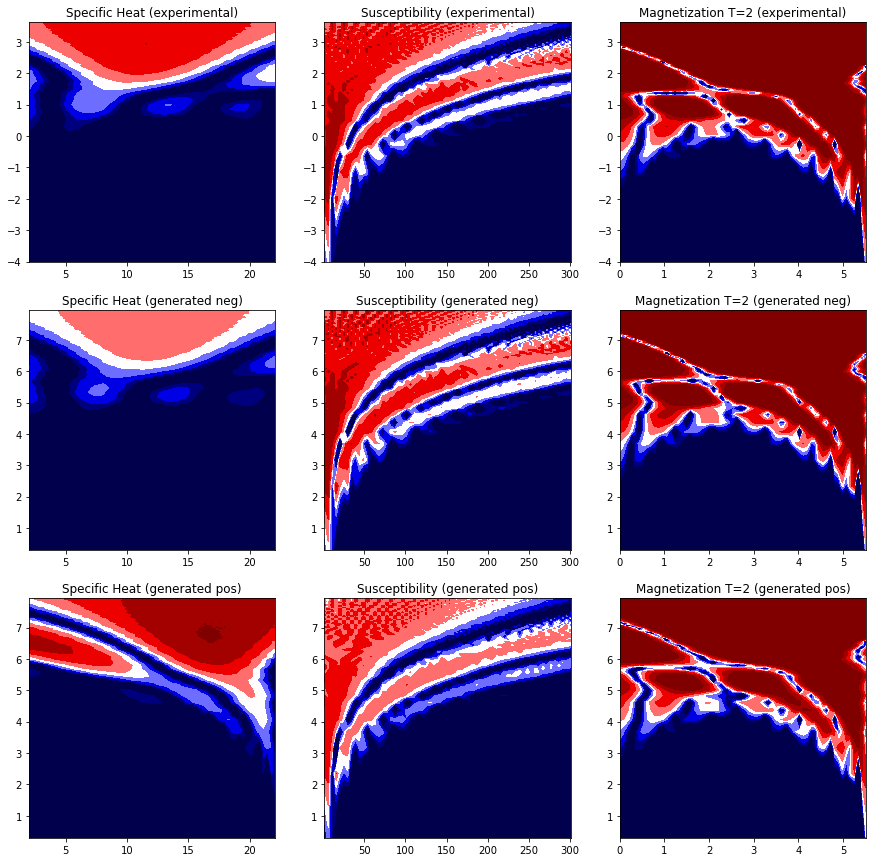

In [18]:
scale = np.linspace(1, 200, 64)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
contourlevels = np.log2(levels)
wave = 'morl'

fig, ax = plt.subplots(3, 3, figsize=(15,15))

[susc_coeff, susc_freq] = pywt.cwt(chi, scale, wave, 0.05)
susc_power = (abs(susc_coeff)) ** 2
susc_period = 1. / susc_freq

[sheat_coeff, sheat_freq] = pywt.cwt(spec, scale, wave, 0.05)
sheat_power = (abs(sheat_coeff)) ** 2
sheat_period = 1. / sheat_freq

[low_coeff, low_freq] = pywt.cwt(mag, scale, wave, 0.05)
low_power = (abs(low_coeff)) ** 2
low_period = 1. / low_freq

sheat_plot = ax[0,0].contourf(spec_x, np.log2(sheat_period), np.log2(sheat_power), contourlevels, extend='both',cmap=plt.cm.seismic)
ax[0,0].set_title('Specific Heat (experimental)')

susc_plot = ax[0,1].contourf(chi_x, np.log2(susc_period), np.log2(susc_power), contourlevels, extend='both',cmap=plt.cm.seismic)
ax[0,1].set_title('Susceptibility (experimental)')

low_mag_plot = ax[0,2].contourf(mag_x, np.log2(low_period), np.log2(low_power), contourlevels, extend='both',cmap=plt.cm.seismic)
ax[0,2].set_title('Magnetization T=2 (experimental)')

# ----------------------------------------------------------

[susc_coeff, susc_freq] = pywt.cwt(np.array(exp_out_neg[2])[:,:,1].flatten(), scale, wave, 1)
susc_power = (abs(susc_coeff)) ** 2
susc_period = 1. / susc_freq

[sheat_coeff, sheat_freq] = pywt.cwt(np.array(exp_out_neg[1])[:,:,1].flatten(), scale, wave, 1)
sheat_power = (abs(sheat_coeff)) ** 2
sheat_period = 1. / sheat_freq

[low_coeff, low_freq] = pywt.cwt(np.array(exp_out_neg[3])[:,:,0,2].flatten(), scale, wave, 1)
low_power = (abs(low_coeff)) ** 2
low_period = 1. / low_freq

sheat_plot = ax[1,0].contourf(spec_x, np.log2(sheat_period), np.log2(sheat_power), contourlevels, extend='both',cmap=plt.cm.seismic)
ax[1,0].set_title('Specific Heat (generated neg)')

susc_plot = ax[1,1].contourf(chi_x, np.log2(susc_period), np.log2(susc_power), contourlevels, extend='both',cmap=plt.cm.seismic)
ax[1,1].set_title('Susceptibility (generated neg)')

low_mag_plot = ax[1,2].contourf(mag_x, np.log2(low_period), np.log2(low_power), contourlevels, extend='both',cmap=plt.cm.seismic)
ax[1,2].set_title('Magnetization T=2 (generated neg)')

# -----------------------------------------------------------

[susc_coeff, susc_freq] = pywt.cwt(np.array(exp_out_pos[2])[:,:,1].flatten(), scale, wave, 1)
susc_power = (abs(susc_coeff)) ** 2
susc_period = 1. / susc_freq

[sheat_coeff, sheat_freq] = pywt.cwt(np.array(exp_out_pos[1])[:,:,1].flatten(), scale, wave, 1)
sheat_power = (abs(sheat_coeff)) ** 2
sheat_period = 1. / sheat_freq

[low_coeff, low_freq] = pywt.cwt(np.array(exp_out_pos[3])[:,:,0,2].flatten(), scale, wave, 1)
low_power = (abs(low_coeff)) ** 2
low_period = 1. / low_freq

sheat_plot = ax[2,0].contourf(spec_x, np.log2(sheat_period), np.log2(sheat_power), contourlevels, extend='both',cmap=plt.cm.seismic)
ax[2,0].set_title('Specific Heat (generated pos)')

susc_plot = ax[2,1].contourf(chi_x, np.log2(susc_period), np.log2(susc_power), contourlevels, extend='both',cmap=plt.cm.seismic)
ax[2,1].set_title('Susceptibility (generated pos)')

low_mag_plot = ax[2,2].contourf(mag_x, np.log2(low_period), np.log2(low_power), contourlevels, extend='both',cmap=plt.cm.seismic)
ax[2,2].set_title('Magnetization T=2 (generated pos)')

plt.show()